In this Notebook, We tested, wrote and run all the plots used in our website. You can also find examples of plots we didn't kept because we finds a lack of coherence with our story.

In [179]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
import os
import sys
import plotly.graph_objects as go
import statsmodels.api as sm
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots

import statsmodels.api as sm
import random
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import networkx as nx

from importlib import reload
import src.utils.utils
reload(src.utils.utils)

# fix random seed for reproducibility
np.random.seed(42)
random.seed(42)

In [3]:
data_folder = './data/'
pickle_folder = data_folder + 'pickle/'
imdb_folder = data_folder + 'IMDB/'
cmu_folder = data_folder + 'CMU/'

In [200]:
with open(pickle_folder+"movies_clean.p", 'rb') as f:
    movies_clean = pickle.load(f)
with open(pickle_folder+"movies_clean_with_season.p", 'rb') as f:
    movies_season = pickle.load(f)
with open(pickle_folder+"characters_clean.p", 'rb') as f:
    characters_clean = pickle.load(f)

In [5]:
def top_10_(df,feature):
    # top 30 rated movies
    top30_ = df.sort_values(by="averageRating",ascending=False).head(30)
    
    top10 = top30_[[x for x in top30_.columns if x.startswith(feature)]].sum(axis=0).sort_values(ascending=False).head(10)
    return top10

In [6]:
periods = sorted(movies_clean["Year_Interval"].unique())
periods

['1915-1930', '1930-1950', '1950-1970', '1970-2000', '2000-2015']

# 1915-1930 (The Silent Era)

In [7]:
period0 = periods[0]
df_period0 = movies_clean[movies_clean["Year_Interval"] == period0]

/var/folders/gc/k740v3612cv_1m5s2d93wxzr0000gn/T/ipykernel_79750/1529481055.py:4: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



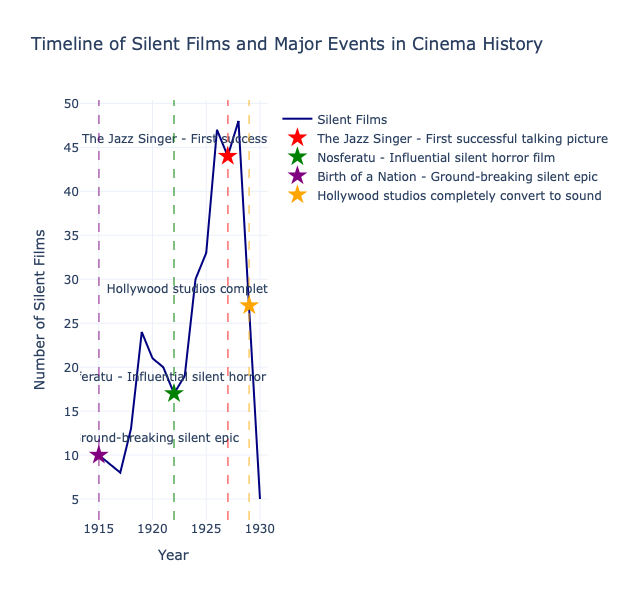

In [219]:
# There is a before and an after "The Jazz Singer" in 1927. The apparition of the sound really changed the
# whole picture for the whole cinema industry

df = pd.DataFrame(df_period0[df_period0["Genre_Silent film"]==True].groupby("Year").apply(lambda x: x["Genre_Silent film"].sum()),columns=["count"]).reset_index()


# Create the events data
events = {
    1927: {'text': 'The Jazz Singer - First successful talking picture', 'color': 'red'},
    1922: {'text': 'Nosferatu - Influential silent horror film', 'color': 'green'},
    1915: {'text': 'Birth of a Nation - Ground-breaking silent epic', 'color': 'purple'},
    1929: {'text': 'Hollywood studios completely convert to sound', 'color': 'orange'}
}

# Create the main line plot
fig = go.Figure()

# Add the silent films line
fig.add_trace(
    go.Scatter(
        x=df['Year'],
        y=df['count'],
        mode='lines',
        name='Silent Films',
        line=dict(color='navy', width=2)
    )
)

# Add event markers
for year, event in events.items():
    fig.add_trace(
        go.Scatter(
            x=[year],
            y=[df[df['Year'] == year]['count'].values[0]],
            mode='markers+text',
            name=event['text'],
            marker=dict(
                symbol='star',
                size=15,
                color=event['color']
            ),
            text=event['text'],
            textposition='top center',
            hoverinfo='text+x+y',
            showlegend=True
        )
    )

# Add vertical lines for events
for year, event in events.items():
    fig.add_vline(
        x=year,
        line_dash="dash",
        line_color=event['color'],
        opacity=0.5
    )

# Update layout
fig.update_layout(
    title='Timeline of Silent Films and Major Events in Cinema History',
    xaxis_title='Year',
    yaxis_title='Number of Silent Films',
    hovermode='closest',
    template='plotly_white',
    showlegend=True,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=1.05
    ),
    margin=dict(r=200)  # Add right margin for legend
)

# Make it responsive
fig.update_layout(
    autosize=True,
    width=1000,
    height=600
)

# Show the plot
fig.show()

fig.write_html("plots/timeline_chapter1.html")

Top 10 most frequent genres in the 30 highest-rated movies :


Genre_Drama              29
Genre_Black-and-white    27
Genre_Silent film        26
Genre_Romance            11
Genre_Comedy              9
Genre_World cinema        8
Genre_War                 7
Genre_Action              7
Genre_Adventure           5
Genre_Horror              4
dtype: int64

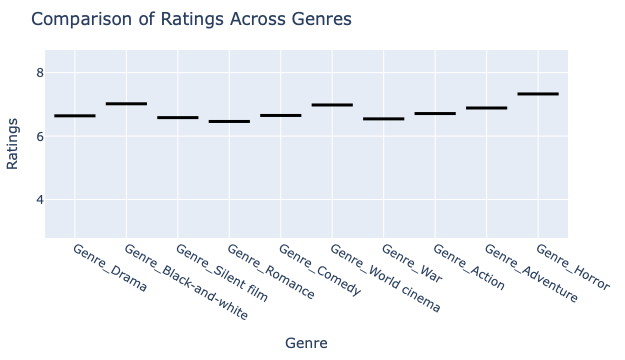

In [218]:
# Silent films compose the major part of this period. However, with the thanks to the apparition of the 
# first "talkies" and sound in cinema, there is the emergence of established genres like Drama, comedy 
# or musical.
# The World Cinema genre is highly rated during 1915-1930 due to groundbreaking innovations and especially 
# the rise of talkies, which transformed storytelling, and the emergence of unique cinematic styles.
print("Top 10 most frequent genres in the 30 highest-rated movies :")
top = top_10_(df_period0,'Genre_')
display(top)

df = df_period0[[x for x in top.index.to_list()]+['averageRating']]
# Melt the dataset to a long format for easier visualization
df_long = df.melt(id_vars=['averageRating'], 
                  value_vars=[x for x in top.index.to_list()], 
                  var_name="Genre", 
                  value_name="Belongs_To_Genre")

# Filter only rows where the movie belongs to a genre (value == 1)
df_long = df_long[df_long["Belongs_To_Genre"] == True]

# Calculate mean ratings for each genre
mean_ratings = df_long.groupby('Genre')['averageRating'].mean().reset_index()

# Create the scatter plot
fig = px.scatter(df_long, x="Genre", y="averageRating", 
                color="Genre", 
                title="Comparison of Ratings Across Genres", 
                labels={"averageRating": "Ratings", "Genre": "Genre"}, 
                hover_data=["averageRating"])

# Add horizontal bars for mean ratings
for idx, row in mean_ratings.iterrows():
    fig.add_shape(
        type='line',
        x0=idx-0.4,  # Extend the line a bit to the left
        x1=idx+0.4,  # Extend the line a bit to the right
        y0=row['averageRating'],
        y1=row['averageRating'],
        line=dict(color='black', width=3)
    )

# Update layout for better aesthetics
fig.update_layout(
    showlegend=False,
    margin=dict(t=50, l=25, r=25, b=25)
)

fig.show()
fig.write_html("plots/ratings_comparison_chapter1.html")

In [115]:
from sklearn.neighbors import NearestNeighbors

char0 = characters_clean[characters_clean["Year_Interval"]==period0]

data = char0.merge(df_period0[["Wikipedia_movie_ID"]+[x for x in df_period0.columns if x.startswith("Genre_")]],how="left",on="Wikipedia_movie_ID")

df = pd.DataFrame(data)
# Create dummy variables for categorical features (gender and genre)
df = pd.get_dummies(df, columns=['Actor_gender'], drop_first=True)

# Logistic regression to calculate propensity scores
X = df[['Actor_age_at_movie_release', 'Actor_gender_M']+[x for x in df_period0.columns if x.startswith("Genre_")]]  # Independent variables
y = np.ones(len(df))  # Since every row is a character that was cast in a movie, so y=1

# Add a constant for the intercept in the regression
X = np.asarray(sm.add_constant(X))

# Fit logistic regression model to predict the propensity score
model = sm.Logit(y, X)
result = model.fit()

# Predicted probabilities (propensity scores)
df['propensity_score'] = result.predict(X)

# Separate males and females
male_df = df[df['Actor_gender_M'] == 1]
female_df = df[df['Actor_gender_M'] == 0]

# Nearest neighbor matching based on propensity score
nn = NearestNeighbors(n_neighbors=1)
nn.fit(male_df[['propensity_score']])

# Find the nearest female match for each male
distances, indices = nn.kneighbors(female_df[['propensity_score']])

# Create matched female dataframe based on nearest neighbors
matched_female_df = female_df.iloc[indices.flatten()]

# Combine matched male and female data
matched_df = pd.concat([male_df, matched_female_df])

# Compute the probability of being cast (in this case, everyone is cast, but we calculate the result post-matching)
probability = matched_df.groupby('Actor_gender_M')['propensity_score'].mean()

# Visualize the results in a bar plot
sns.barplot(x=probability.index.map({0: 'Female', 1: 'Male'}), y=probability.values)
plt.title('Propensity Score of Being Cast (After Matching for Age and Genre)')
plt.xlabel('Gender')
plt.ylabel('Propensity Score (Probability of Being Cast)')
plt.show()


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

# 1930 - 1950 (Hollywood's Golden Age)

In [30]:
period1 = periods[1]
df_period1 = movies_clean[movies_clean["Year_Interval"] == period1]

/var/folders/gc/k740v3612cv_1m5s2d93wxzr0000gn/T/ipykernel_79750/1580385311.py:22: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



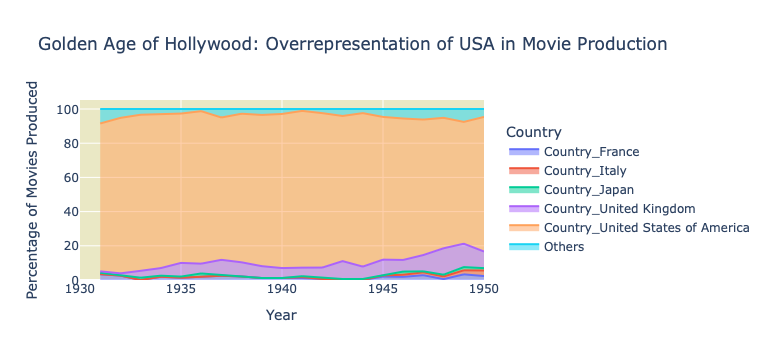

In [216]:
# Step 1: Aggregate by year for all countries
# Melt the binary columns to create a 'Country' column with corresponding values
country_columns = [col for col in df_period1.columns if col.startswith('Country_')]
df_melted = df_period1.melt(
    id_vars=['Year'], 
    value_vars=country_columns, 
    var_name='Country', 
    value_name='Movie_Count'
)

# Keep only rows where Movie_Count is 1 (indicating that a movie was produced in that country)
df_melted = df_melted[df_melted['Movie_Count'] == 1]

# Step 2: Count the number of movies per country per year
df_grouped = df_melted.groupby(['Year', 'Country']).size().reset_index(name='Movie_Count')

# Step 3: Calculate the total number of movies per year and percentages per country
df_grouped['Total_Per_Year'] = df_grouped.groupby('Year')['Movie_Count'].transform('sum')
df_grouped['Percentage'] = (df_grouped['Movie_Count'] / df_grouped['Total_Per_Year']) * 100

# Combine smaller countries into an "Others" category (countries with less than 5% representation)
top5_producer = df_grouped.groupby('Country').apply(lambda x: x["Percentage"].mean()).sort_values(ascending=False).head(6).index.to_list()

df_grouped['Country'] = df_grouped.apply(
    lambda row: row['Country'] if row['Country'] in top5_producer and row['Country']!='Country_Other' else 'Others', axis=1
)

# Recalculate percentages after combining smaller countries into "Others"
df_grouped = df_grouped.groupby(['Year', 'Country']).agg(
    {'Movie_Count': 'sum', 'Total_Per_Year': 'first'}
).reset_index()
df_grouped['Percentage'] = (df_grouped['Movie_Count'] / df_grouped['Total_Per_Year']) * 100

df_grouped.sort_values("Country",inplace=True)
# Step 4: Plot the stacked area chart
fig = px.area(
    df_grouped,
    x='Year',
    y='Percentage',
    color='Country',
    title='Golden Age of Hollywood: Overrepresentation of USA in Movie Production',
    labels={'Percentage': 'Percentage of Movies Produced', 'Year': 'Year', 'Country': 'Country'},
)

# Highlight the Golden Age of Hollywood (1930-1950) with a shaded background
fig.add_vrect(
    x0=1930, x1=1950,
    fillcolor="gold", opacity=0.2,
    layer="below", line_width=0,
)

# Update layout for better visuals
fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Percentage of Movies Produced",
    legend_title="Country",
    legend=dict(
        orientation="v",   # Set vertical orientation
        yanchor="middle",  # Anchor legend vertically in the middle
        y=0.5,             # Center legend vertically
        xanchor="left",    # Anchor legend horizontally to the left
        x=1.05             # Position legend slightly to the right of the plot
    ),
)

# Show the plot
fig.show()

fig.write_html("plots/film_production_chapter2.html")

(3800, 61)

/var/folders/gc/k740v3612cv_1m5s2d93wxzr0000gn/T/ipykernel_79750/1174681828.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/gc/k740v3612cv_1m5s2d93wxzr0000gn/T/ipykernel_79750/1174681828.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/gc/k740v3612cv_1m5s2d93wxzr0000gn/T/ipykernel_79750/1174681828.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

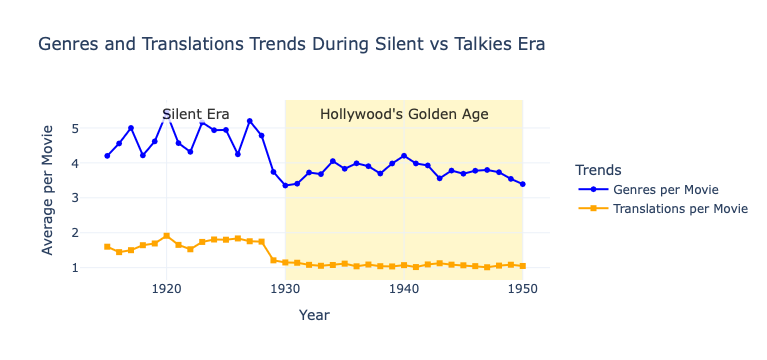

In [215]:
# Sample dataset structure
# df = pd.DataFrame({
#     'Year': [1920, 1925, 1935, 1945],
#     'Num_Genres': [2, 3, 1, 1],
#     'Num_Translations': [1, 1, 3, 4],
#     'Era': ['Silent', 'Silent', 'Talkies', 'Talkies']
# })

periods01 = [period0,period1]
df = movies_clean[movies_clean["Year_Interval"].isin(periods01)]
display(df.shape)

# Step 1: Create a binary variable for Silent vs Talkies Era
df['Era'] = np.where(df['Year_Interval'] == '1915-1930', 'Silent', 'Talkies')

# Step 2: Propensity Score Matching
# Define the treatment variable (Talkies = 1, Silent = 0)
df['Talkies'] = np.where(df['Era'] == 'Talkies', 1, 0)

# Standardize the features for matching
features = ['nb_of_Genres', 'nb_of_Languages']
X = df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Propensity score model
y = df['Talkies']
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
model = LogisticRegression()
model.fit(X_train, y_train)
df['Propensity_Score'] = model.predict_proba(X_scaled)[:, 1]

# Matching
# We match movies in the Silent Era to movies in the Talkies Era based on similar propensity scores
silent = df[df['Talkies'] == 0].copy()
talkies = df[df['Talkies'] == 1].copy()

# Nearest neighbor matching
silent['Matched_Talkies'] = silent['Propensity_Score'].apply(
    lambda x: talkies.iloc[(talkies['Propensity_Score'] - x).abs().argsort()[:1]].index[0]
)

# Step 3: Aggregate trends for plotting
df_grouped = df.groupby(['Year', 'Era'])[['nb_of_Genres', 'nb_of_Languages']].mean().reset_index()

# Step 4: Create the simplified dual plot
fig = go.Figure()

# Single line for Number of Genres per Movie
fig.add_trace(go.Scatter(
    x=df_grouped['Year'],
    y=df_grouped['nb_of_Genres'],
    mode='lines+markers',
    name='Genres per Movie',
    line=dict(color='blue'),
    marker=dict(symbol='circle')
))

# Single line for Number of Translations per Movie
fig.add_trace(go.Scatter(
    x=df_grouped['Year'],
    y=df_grouped['nb_of_Languages'],
    mode='lines+markers',
    name='Translations per Movie',
    line=dict(color='orange'),
    marker=dict(symbol='square')
))

# Highlight the Silent Era (1915-1930) with a shaded background
fig.add_vrect(
    x0=1915, x1=1930,
    fillcolor="white", opacity=0.2,
    layer="below", line_width=0,
)

# Highlight the Golden Age of Hollywood (1930-1950) with a shaded background
fig.add_vrect(
    x0=1930, x1=1950,
    fillcolor="gold", opacity=0.2,
    layer="below", line_width=0,
)

# Add annotations for the Silent Era and Golden Age
fig.add_annotation(
    x=1922.5, y=max(df_grouped['nb_of_Genres']),
    text="Silent Era",
    showarrow=False,
    font=dict(size=14, color="black"),
    bgcolor="white",
    opacity=0.8
)
fig.add_annotation(
    x=1940, y=max(df_grouped['nb_of_Genres']),
    text="Hollywood's Golden Age",
    showarrow=False,
    font=dict(size=14, color="black"),
    opacity=0.8
)

# Add titles and labels
fig.update_layout(
    title="Genres and Translations Trends During Silent vs Talkies Era",
    xaxis_title="Year",
    yaxis_title="Average per Movie",
    legend_title="Trends",
    legend=dict(
        orientation="v",   # Set vertical orientation
        yanchor="middle",  # Anchor legend vertically in the middle
        y=0.5,             # Center legend vertically
        xanchor="left",    # Anchor legend horizontally to the left
        x=1.05             # Position legend slightly to the right of the plot
    ),
    template="plotly_white"
)

# Show the plot
fig.show()

fig.write_html("plots/film_genres_languages_chapter2.html")

- Visualization Idea: A box plot of box office revenues across the two time periods, highlighting outliers like Gone with the Wind.


- Show correlation between adventure, action and crime dramas and male dominance in those movies / psm maybe
Show that Great Depression coincided with the rise of these genres in cinema.
Which conforts the fact that male were twice as represented as women in this period.

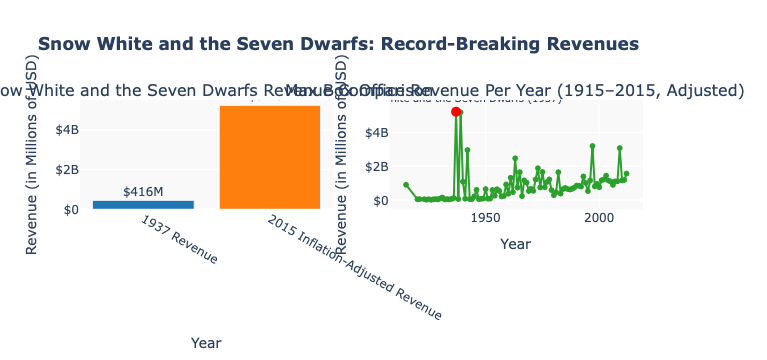

In [214]:
df_mod_clean = movies_clean.dropna(subset='Movie_box_office_revenue')
cpi = pd.read_csv("./data/CPI.csv")

cpi = pd.DataFrame(cpi.groupby('year').apply(lambda x: x['value'].mean(),include_groups=False),columns=['cpi'])
base_cpi = cpi.loc[2015].values[0]

df_mod_cpi = df_mod_clean.merge(cpi,left_on='Year',right_on='year',how='left')
df_mod_cpi['Adjusted_Revenue'] = df_mod_cpi['Movie_box_office_revenue']*(base_cpi/df_mod_cpi['cpi'])

max_rev_per_year = pd.DataFrame(df_mod_cpi.groupby('Year').apply(lambda x: x['Adjusted_Revenue'].max(),include_groups=False),columns=['Max_Revenue']).reset_index()

value_1937 = df_mod_cpi[df_mod_cpi["Movie_name"]=="Snow White and the Seven Dwarfs"]["Movie_box_office_revenue"].values[0]
value_2015 = df_mod_cpi[df_mod_cpi["Movie_name"]=="Snow White and the Seven Dwarfs"]["Adjusted_Revenue"].values[0]

text_1937 = f"${round(value_1937/1000000)}M"
text_2015 = f"${round(value_2015/1000000000,2)}B"
# Create a bar chart
fig1 = go.Figure()

# Add bars
fig1.add_trace(go.Bar(
    x=["1937 Revenue", "2015 Inflation-Adjusted Revenue"],
    y=[value_1937, value_2015],
    text=[text_1937, text_2015],  # Add labels above bars
    textposition='outside',
    marker=dict(color=["#1f77b4", "#ff7f0e"])  # Use distinct colors
))

# Customize layout
fig1.update_layout(
    title="<b>Revenue of Snow White and the Seven Dwarfs: Original vs Inflation-Adjusted</b>",
    xaxis_title="Revenue Type",
    yaxis_title="Revenue (in Millions of USD)",
    yaxis=dict(tickprefix="$"),
    plot_bgcolor="#f9f9f9",
    font=dict(size=14),
    annotations=[
        dict(
            x=0, y=value_1939 + 100,
            text="Record-breaking in 1937!",
            showarrow=True,
            arrowhead=2, arrowcolor="#1f77b4",
            ax=20, ay=-40
        ),
        dict(
            x=1, y=value_2015 + 200,
            text="Highest-grossing film (inflation-adjusted)",
            showarrow=True,
            arrowhead=2, arrowcolor="#ff7f0e",
            ax=-40, ay=-80
        )
    ]
)

# Second Plot: Max Revenue per Year (Inflation-Adjusted)
fig2 = go.Figure()
fig2.add_trace(go.Scatter(
    x=max_rev_per_year["Year"],
    y=max_rev_per_year["Max_Revenue"],
    mode="lines+markers",
    line=dict(color="#2ca02c"),
    name="Max Revenue"
))
fig2.add_trace(go.Scatter(
    x=[1937],
    y=[value_2015],
    mode="markers+text",
    marker=dict(size=10, color="red"),
    text=["Snow White and the Seven Dwarfs (1937)"],
    textposition="top center",
    textfont=dict(size=10),
    name="Snow White and the Seven Dwarfs"
))
fig2.update_layout(
    title="Max Box Office Revenue Per Year (1915–2015, Adjusted)",
    xaxis_title="Year",
    yaxis_title="Revenue (in Millions of USD)",
    yaxis=dict(tickprefix="$"),
    plot_bgcolor="#f9f9f9",
    font=dict(size=14)
)

from plotly.subplots import make_subplots
combined_fig = make_subplots(rows=1, cols=2, subplot_titles=[
    "Snow White and the Seven Dwarfs Revenue Comparison",
    "Max Box Office Revenue Per Year (1915–2015, Adjusted)"
])

# Add plots to the subplots
combined_fig.add_trace(fig1.data[0], row=1, col=1)  # First plot
for trace in fig2.data:  # Second plot (with multiple traces)
    combined_fig.add_trace(trace, row=1, col=2)

# Update layout for the combined figure
combined_fig.update_layout(
    title_text="<b>Snow White and the Seven Dwarfs: Record-Breaking Revenues</b>",
    showlegend=False,  # Remove legend for simplicity
    plot_bgcolor="#f9f9f9",
    font=dict(size=12),
    xaxis1=dict(title="Year"),  # Adjust axis titles for subplots
    yaxis1=dict(title="Revenue (in Millions of USD)", tickprefix="$"),
    xaxis2=dict(title="Year"),
    yaxis2=dict(title="Revenue (in Millions of USD)", tickprefix="$")
)

# Show the combined plot
combined_fig.show()

combined_fig.write_html("plots/revenue_record_chapter2.html")

/var/folders/gc/k740v3612cv_1m5s2d93wxzr0000gn/T/ipykernel_79750/1173520843.py:4: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/gc/k740v3612cv_1m5s2d93wxzr0000gn/T/ipykernel_79750/1173520843.py:5: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/gc/k740v3612cv_1m5s2d93wxzr0000gn/T/ipykernel_79750/1173520843.py:6: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping col

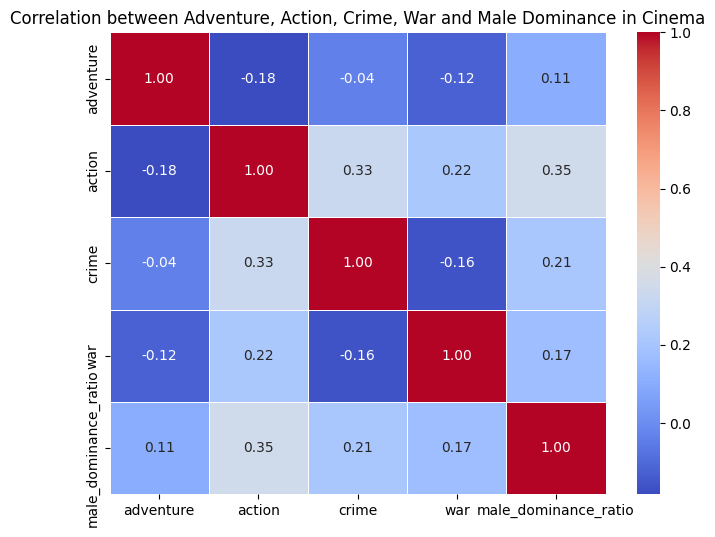

Regression Coefficients: [0.00575328 0.01109601 0.00475621 0.00503363]
Mean Squared Error: 0.00028238978232857163


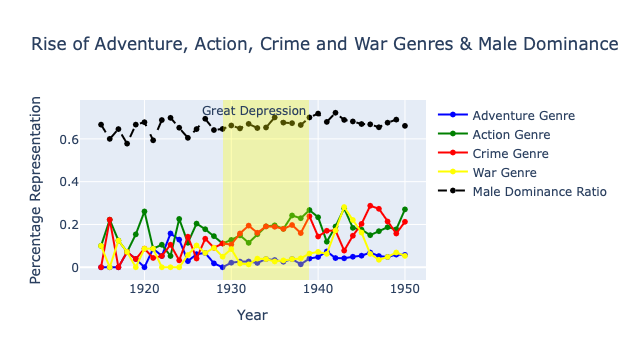

In [55]:
periods01 = [period0,period1]
df_advc = movies_clean[movies_clean["Year_Interval"].isin(periods01)]
df = pd.DataFrame()
df["action"] = df_advc.groupby("Year").apply(lambda x: x["Genre_Action"].mean())
df["adventure"] = df_advc.groupby("Year").apply(lambda x: x["Genre_Adventure"].mean())
df["crime"] = df_advc.groupby("Year").apply(lambda x: x["Genre_Crime"].mean())
df["war"] = df_advc.groupby("Year").apply(lambda x: x["Genre_War"].mean())

char1 = characters_clean[characters_clean["Year_Interval"].isin(periods01)].copy()
dummies = pd.get_dummies(char1['Actor_gender'], prefix = 'gender')
char1 = char1.merge(dummies, left_index=True, right_index=True)
df["male_representation"] = char1.groupby("Year").apply(lambda x: x["gender_M"].mean())
df["female_representation"] = char1.groupby("Year").apply(lambda x: x["gender_F"].mean())

# Adding a column for male dominance ratio
df["male_dominance_ratio"] = df["male_representation"] / (df["male_representation"] + df["female_representation"])

# Create a correlation matrix
corr_matrix = df[['adventure', 'action', 'crime', 'war', 'male_dominance_ratio']].corr()

# Plotting the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation between Adventure, Action, Crime, War and Male Dominance in Cinema")
plt.show()

# Linear regression model to analyze the relationship between genres and male dominance
X = df[['adventure', 'action', 'crime', 'war']]
y = df['male_dominance_ratio']

df = df.reset_index()
# Standardizing the data for better results in regression
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predicting and calculating MSE
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

# Show the regression coefficients
print(f"Regression Coefficients: {model.coef_}")
print(f"Mean Squared Error: {mse}")

# Now plot the genres over time to show the rise of these genres during the Great Depression
fig = go.Figure()

# Plotting each genre
fig.add_trace(go.Scatter(
    x=df['Year'],
    y=df['adventure'],
    mode='lines+markers',
    name='Adventure Genre',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=df['Year'],
    y=df['action'],
    mode='lines+markers',
    name='Action Genre',
    line=dict(color='green')
))

fig.add_trace(go.Scatter(
    x=df['Year'],
    y=df['crime'],
    mode='lines+markers',
    name='Crime Genre',
    line=dict(color='red')
))

fig.add_trace(go.Scatter(
    x=df['Year'],
    y=df['war'],
    mode='lines+markers',
    name='War Genre',
    line=dict(color='yellow')
))

# Plotting male dominance ratio
fig.add_trace(go.Scatter(
    x=df['Year'],
    y=df['male_dominance_ratio'],
    mode='lines+markers',
    name='Male Dominance Ratio',
    line=dict(color='black', dash='dash')
))

# Highlight the Great Depression period (1929-1939)
fig.add_vrect(
    x0=1929, x1=1939,
    annotation_text="Great Depression",
    annotation_position="top right",
    fillcolor="yellow", opacity=0.3,
    line_width=0,
)

fig.update_layout(
    title="Rise of Adventure, Action, Crime and War Genres & Male Dominance During the Great Depression",
    xaxis_title="Year",
    yaxis_title="Percentage Representation",
    showlegend=True
)

fig.show()

/var/folders/gc/k740v3612cv_1m5s2d93wxzr0000gn/T/ipykernel_79750/1722969753.py:4: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/gc/k740v3612cv_1m5s2d93wxzr0000gn/T/ipykernel_79750/1722969753.py:5: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/gc/k740v3612cv_1m5s2d93wxzr0000gn/T/ipykernel_79750/1722969753.py:6: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping col

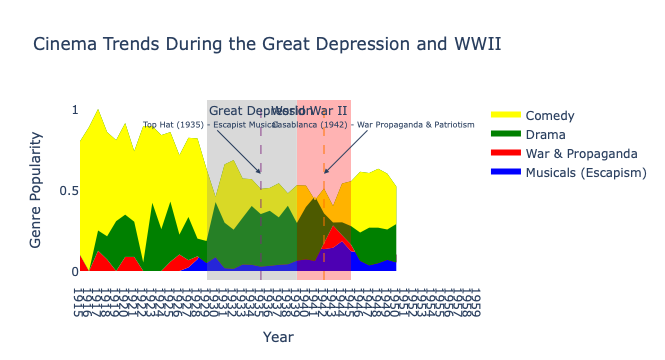

In [213]:
periods01 = [period0,period1]
df_advc = movies_clean[movies_clean["Year_Interval"].isin(periods01)]
df = pd.DataFrame()
df["musicals"] = df_advc.groupby("Year").apply(lambda x: x["Genre_Musical"].mean())
df["war_propaganda"] = df_advc.groupby("Year").apply(lambda x: x["Genre_War"].mean())
df["drama"] = df_advc.groupby("Year").apply(lambda x: x["Genre_Drama"].mean())
df["comedy"] = df_advc.groupby("Year").apply(lambda x: x["Genre_Comedy"].mean())
df = df.reset_index()
# Plot
fig = go.Figure()

# Stack genres to show relative proportions
fig.add_trace(go.Scatter(
    x=df['Year'],
    y=df['musicals'],
    fill='tonexty',
    mode='none',
    name='Musicals (Escapism)',
    fillcolor='blue'
))

fig.add_trace(go.Scatter(
    x=df['Year'],
    y=df['war_propaganda'],
    fill='tonexty',
    mode='none',
    name='War & Propaganda',
    fillcolor='red'
))

fig.add_trace(go.Scatter(
    x=df['Year'],
    y=df['drama'],
    fill='tonexty',
    mode='none',
    name='Drama',
    fillcolor='green'
))

fig.add_trace(go.Scatter(
    x=df['Year'],
    y=df['comedy'],
    fill='tonexty',
    mode='none',
    name='Comedy',
    fillcolor='yellow'
))

# Add annotations for key films
fig.add_annotation(
    x=1935, y=0.6,
    text="Top Hat (1935) - Escapist Musical",
    font=dict(size=8),
    showarrow=True,
    arrowhead=2,
    ax=-50,
    ay=-50
)

fig.add_annotation(
    x=1942, y=0.6,
    text="Casablanca (1942) - War Propaganda & Patriotism",
    font=dict(size=8),
    showarrow=True,
    arrowhead=2,
    ax=50,
    ay=-50
)

fig.add_vline(
        x=1935,
        line_dash="dash",
        line_color="purple",
        opacity=0.5
)

fig.add_vline(
        x=1942,
        line_dash="dash",
        line_color="orange",
        opacity=0.5
)

# Highlight the Great Depression period (1929–1939)
fig.add_vrect(
    x0=1929, x1=1939,
    annotation_text="Great Depression",
    annotation_position="top left",
    fillcolor="grey", opacity=0.3,
    line_width=0,
)

# Highlight the WWII period (1939–1945)
fig.add_vrect(
    x0=1939, x1=1945,
    annotation_text="World War II",
    annotation_position="top right",
    fillcolor="red", opacity=0.3,
    line_width=0,
)

# Update layout for better readability
fig.update_layout(
    title="Cinema Trends During the Great Depression and WWII",
    xaxis_title="Year",
    yaxis_title="Genre Popularity",
    showlegend=True,
    xaxis=dict(tickmode='linear', tick0=1930, dtick=1),
    plot_bgcolor='white'
)

# Show plot
fig.show()

fig.write_html("plots/theme_evolution_chapter2.html")

# 1950-1970

In [116]:
period2 = periods[2]
df_period2 = movies_clean[movies_clean["Year_Interval"]==period2]

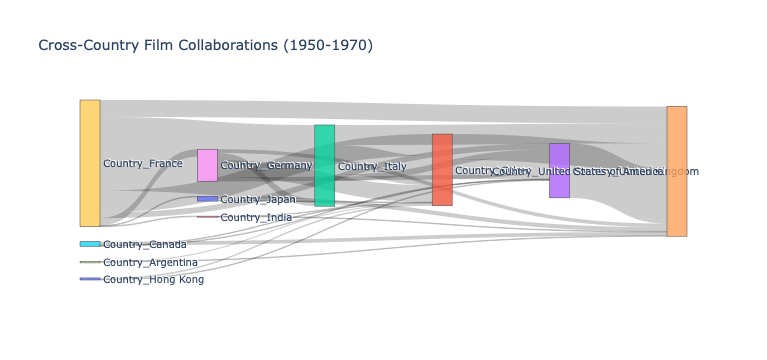

In [212]:
# Step 1: Find pairs of countries involved in the same movie
df = df_period2[[x for x in df_period2.columns if x.startswith("Country_")]]
co_prod = []
countries = df.columns
for _, row in df.iterrows():
    involved_countries = countries[row == 1]
    pairs = [(c1, c2) for i, c1 in enumerate(involved_countries) for c2 in involved_countries[i+1:]]
    co_prod.extend(pairs)

# Step 2: Create a DataFrame with counts of each pair
co_prod_df = pd.DataFrame(co_prod, columns=['country_1', 'country_2'])
co_prod_df = co_prod_df.groupby(['country_1', 'country_2']).size().reset_index(name='count')

# Step 3: Create the Sankey plot
unique_countries = list(set(co_prod_df['country_1']).union(set(co_prod_df['country_2'])))

fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        label=unique_countries
    ),
    link=dict(
        source=[unique_countries.index(c1) for c1 in co_prod_df['country_1']],
        target=[unique_countries.index(c2) for c2 in co_prod_df['country_2']],
        value=co_prod_df['count']
    )
))

fig.update_layout(title_text="Cross-Country Film Collaborations (1950-1970)", font_size=10)
fig.show()

fig.write_html("plots/films_collaborations_chapter3.html")

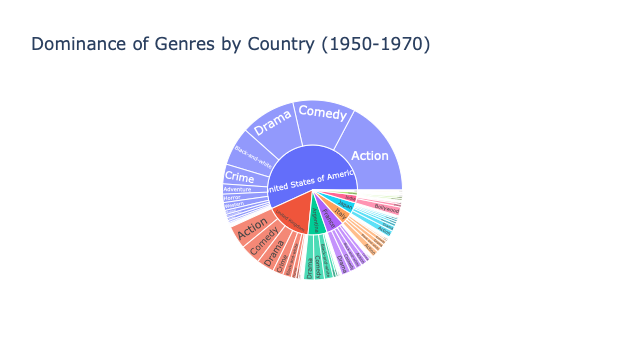

In [281]:
# After get_dummies, you have columns like 'country_United States', 'country_France', 'genre_Adventure', etc.
# We need to first sum the values across the genres for each country, then reshape the data.
df = df_period2.copy()
# Sum the values for each genre-country pair
genre_country = df.groupby([col for col in df.columns if col.startswith('Country_') and not col=="Country_Other"] + 
                           [col for col in df.columns if col.startswith('Genre_') and not col=="Genre_Other" ]).size().reset_index(name='count')

# Create a new column for country names and genre names for better visualization
genre_country['country'] = genre_country[[col for col in genre_country.columns if col.startswith('Country_')]].idxmax(axis=1).str.replace('Country_', '')
genre_country['genre'] = genre_country[[col for col in genre_country.columns if col.startswith('Genre_')]].idxmax(axis=1).str.replace('Genre_', '')

# Now, we can plot the data with the sunburst chart
fig = px.sunburst(
    genre_country,
    path=['country', 'genre'],
    values='count',
    title="Dominance of Genres by Country (1950-1970)"
)
fig.show()
fig.write_html("plots/genre_byCountry_chapter3.html")

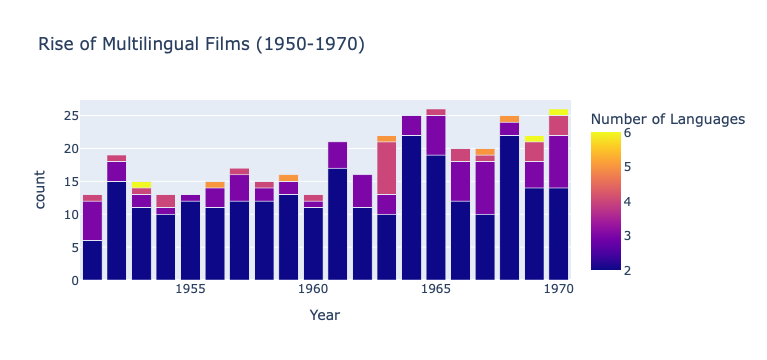

In [210]:
# Group by year and count multilingual films
languages_per_year = df_period2.groupby(['Year', 'nb_of_Languages']).size().reset_index(name='count')

fig = px.bar(
    languages_per_year[languages_per_year["nb_of_Languages"]!=1]
    ,
    x='Year',
    y='count',
    color='nb_of_Languages',
    labels={'nb_of_Languages': 'Number of Languages'},
    title="Rise of Multilingual Films (1950-1970)"
)
fig.show()
fig.write_html("plots/rise_of_languages_chapter3.html")

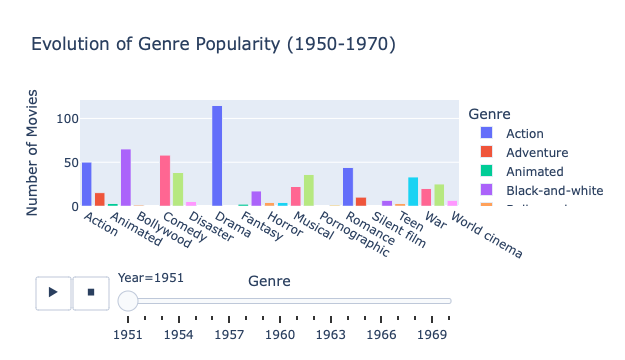

In [303]:
import plotly.express as px

# Group the data by year and each genre column to get the count of movies for each genre
genre_trend = df_period2.groupby('Year')[[col for col in df.columns if col.startswith('Genre_')]].sum().reset_index()

# Reshape the data to make it compatible with the bar plot (melt it into a long format)
genre_trend = genre_trend.melt(id_vars=['Year'], var_name='Genre', value_name='count')

# Filter out rows where count is 0 (since it won't be relevant for the plot)
genre_trend = genre_trend[genre_trend['count'] > 0]
genre_trend['Genre'] = genre_trend['Genre'].apply(lambda x: x.replace("Genre_",""))

# Create the bar plot
fig = px.bar(
    genre_trend,
    x='Genre',
    y='count',
    color='Genre',
    animation_frame='Year',
    title="Evolution of Genre Popularity (1950-1970)",
    labels={'count': 'Number of Movies', 'Genre': 'Genre'}
)

fig.show()
fig.write_html("plots/genre_diversification_per_yer_chapter3.html")

# 1970-2000

In [225]:
period3 = periods[3]
df_period3 = movies_clean[movies_clean["Year_Interval"] == period3]
df_period_season3 = movies_season[movies_season["Year_Interval"] == period3]

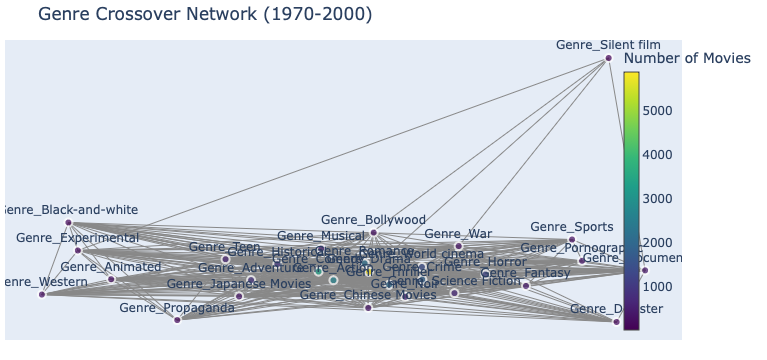

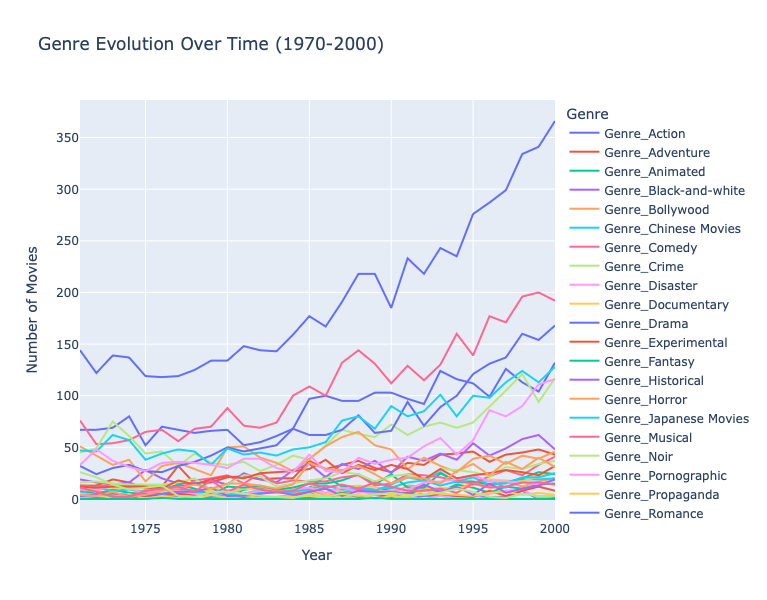

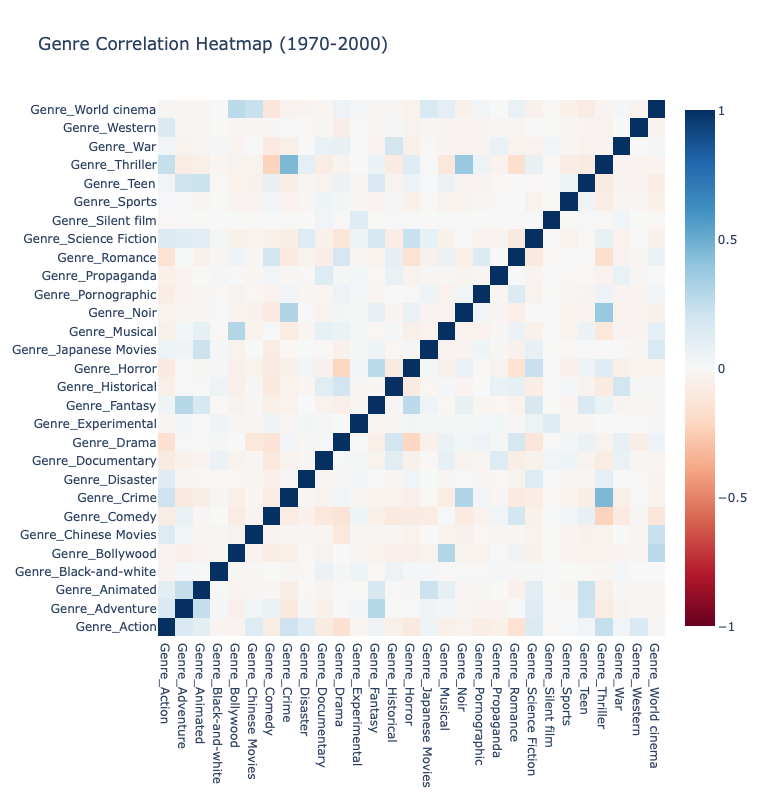

In [318]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import networkx as nx
import plotly.express as px

# Create genre network analysis
def create_genre_network(df):
    genre_pairs = []
    genre_counts = {}
    
    for _, row in df.iterrows():
        # Get genres for the movie (0s and 1s indicating genre presence)
        genres = [col for col in df.columns if col.startswith('Genre_') and row[col] == 1]
        
        # Count individual genres
        for genre in genres:
            if genre not in genre_counts:
                genre_counts[genre] = 0
            genre_counts[genre] += 1
        
        # Count genre pairs (if more than one genre is present for a movie)
        if len(genres) > 1:
            for i in range(len(genres)):
                for j in range(i + 1, len(genres)):
                    genre_pairs.append((genres[i], genres[j]))
    
    # Count pair frequencies
    pair_counts = pd.Series(genre_pairs).value_counts()
    
    # Create a networkx graph
    G = nx.Graph()
    
    # Add nodes (genres) to the graph with their size (frequency of occurrence)
    for genre, count in genre_counts.items():
        G.add_node(genre, size=count)
    
    # Add edges (connections between genres) with weights (frequency of co-occurrence)
    for (genre1, genre2), count in pair_counts.items():
        G.add_edge(genre1, genre2, weight=count)
    
    return G

# Create genre network visualization using Plotly
def create_genre_network_viz(G):
    pos = nx.spring_layout(G, k=1, iterations=50)
    
    # Create edge trace
    edge_x = []
    edge_y = []
    edge_weights = []
    
    for edge in G.edges(data=True):
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
        edge_weights.append(edge[2]['weight'])
    
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=1, color='#888'),
        hoverinfo='none',
        mode='lines')
    
    # Create node trace
    node_x = []
    node_y = []
    node_sizes = []
    node_labels = []
    
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_sizes.append(G.nodes[node]['size'])
        node_labels.append(node)
    
    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        hoverinfo='text',
        text=node_labels,
        textposition="top center",
        marker=dict(
            showscale=True,
            size=[s / 50 for s in node_sizes],
            sizemode='area',
            sizeref=2.*max(node_sizes)/(40.**2),
            sizemin=4,
            color=node_sizes,
            colorscale='Viridis',
            colorbar=dict(
                title='Number of Movies',
                thickness=15,
                x=0.9
            ),
            line_width=2))
    
    # Create the figure with edge and node traces
    fig = go.Figure(data=[edge_trace, node_trace])

    # Add layout and customize appearance
    fig.update_layout(
        title='Genre Crossover Network (1970-2000)',
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20, l=5, r=5, t=40),
        annotations=[],
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
    )

    return fig
  

# Create genre evolution plot
def create_genre_evolution(df):
    genre_counts = df.groupby('Year')[[col for col in df.columns if col.startswith('Genre_')]].sum().reset_index()
    
    genre_counts_melted = genre_counts.melt(id_vars=['Year'], var_name='Genre', value_name='Count')
    
    fig = px.line(genre_counts_melted,
                  x='Year',
                  y='Count',
                  color='Genre',
                  title='Genre Evolution Over Time (1970-2000)')
    
    fig.update_layout(
        xaxis_title='Year',
        yaxis_title='Number of Movies',
        legend_title='Genre',
        height=600
    )
    
    return fig
    
# Create genre correlation heatmap
def create_genre_correlation(df):
    genre_columns = [col for col in df.columns if col.startswith('Genre_')]
    
    corr_matrix = df[genre_columns].corr()

    
    fig = go.Figure(data=go.Heatmap(
        z=corr_matrix.values,
        x=corr_matrix.columns,
        y=corr_matrix.columns,
        colorscale='RdBu',
        zmid=0
    ))
    
    fig.update_layout(
        title='Genre Correlation Heatmap (1970-2000)',
        height=800,
        width=800
    )
    
    return fig
    
# Generate and display visualizations
df = df_period3  # Assuming 'df_period3' is your DataFrame

# Create individual visualizations
network_fig = create_genre_network_viz(create_genre_network(df))
network_fig.show()
network_fig.write_html("plots/genre_network_chapter4.html")

evolution_fig = create_genre_evolution(df)
evolution_fig.show()

correlation_fig = create_genre_correlation(df)
correlation_fig.show()
correlation_fig.write_html("plots/genre_correlation_chapter4.html")

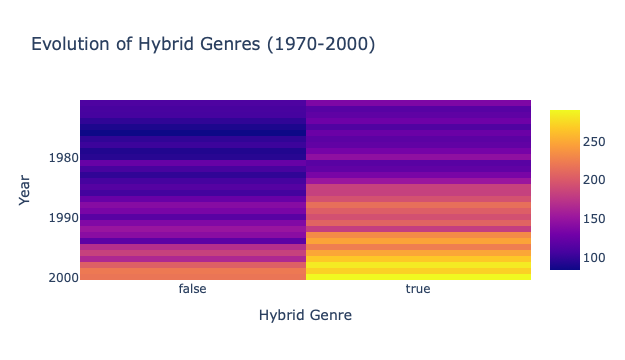

In [239]:
import pandas as pd
import plotly.express as px

df = df_period3.copy()

df['Hybrid_Genre'] = df['Genre_Action'] + df['Genre_Comedy'] + df['Genre_Science Fiction']

# Group by year and hybrid genre (you can adjust hybrid genre combinations)
hybrid_genre_trend = df.groupby(['Year', 'Hybrid_Genre']).size().reset_index(name='Count')

# Create heatmap plot
fig1 = px.imshow(hybrid_genre_trend.pivot(index='Year', columns='Hybrid_Genre', values='Count'),
                 title="Evolution of Hybrid Genres (1970-2000)",
                 labels={'x': 'Hybrid Genre', 'y': 'Year'})
fig1.update_layout(xaxis_title="Hybrid Genre", yaxis_title="Year")
fig1.show()
fig1.write_html("plots/genres_heatmap_chapter4.html")

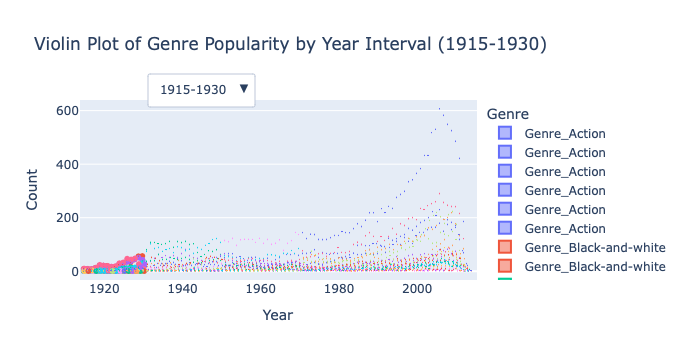

In [231]:
import plotly.express as px
df = movies_clean.copy()

# Assuming df is the dataframe with genre columns such as Genre_Action, Genre_Comedy, etc.
# Melt the dataframe to long format for genre-based analysis
df_melted = df.melt(id_vars=['Year','Year_Interval'], value_vars=[col for col in df.columns if col.startswith('Genre_')],
                    var_name='Genre', value_name='Present')

# Filter only rows where the genre is present (i.e., Present = 1)
df_melted = df_melted[df_melted['Present'] == 1]

# Grouping by year, genre, and interval
genre_trend = df_melted.groupby(['Year_Interval', 'Year', 'Genre']).size().reset_index(name='Count')

# Create the initial violin plot for the first interval (e.g., 1950-1955)
fig = px.violin(genre_trend[genre_trend['Year_Interval'] == period0],
               x='Year', y='Count', color='Genre',
               title="Violin Plot of Genre Popularity by Year Interval (1915-1930)",
               box=True, points="all")

# Create the dropdown to select intervals
intervals = sorted(df_melted['Year_Interval'].unique())

# Add traces for each interval (but hide them initially)
for j in range(len(intervals)):
    fig.add_traces(px.violin(genre_trend[genre_trend['Year_Interval'] == periods[j]],
                            x='Year', y='Count', color='Genre').data)

# Add a dropdown to update the plot based on selected interval
fig.update_layout(
    updatemenus=[dict(
        buttons=[dict(
            args=[{'visible': [True if i == j else False for i in range(len(periods))]},
                  {'title': f"Genre Popularity in {periods[j]}"}],
            label=f'{periods[j]}',
            method='relayout') for j in range(len(intervals))],
        direction='down',
        showactive=True,
        x=0.17,
        xanchor='left',
        y=1.15,
        yanchor='top'
    )]
)

# Show the figure
fig.show()


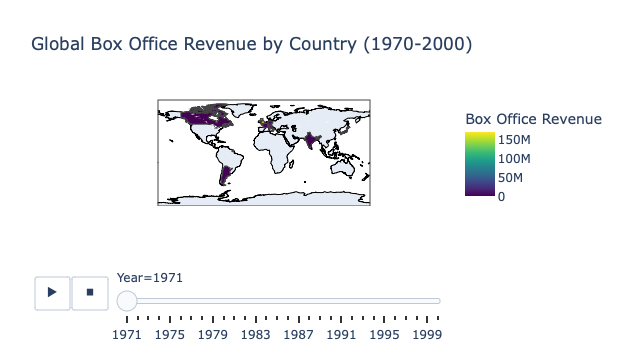

In [262]:
# Assuming df_period3 has a 'Year' column and the data is already in the correct structure
df = df_period3.copy()

# List of country columns (assuming columns are named like 'Country_USA', 'Country_UK', etc.)
country_columns = [col for col in df.columns if col.startswith('Country_') and not col == "Country_United States of America"]

# Aggregate the total box office revenue by country for each year
df_country_revenue_by_year = df.groupby('Year')[country_columns].apply(lambda x: x.multiply(df['Movie_box_office_revenue'], axis=0).sum(axis=0))

# Extract country names from the column names
country_names = [col.split('Country_')[1] for col in country_columns]

# Reshape the DataFrame to make it suitable for Plotly
df_country_revenue = df_country_revenue_by_year.stack().reset_index(name='Movie_box_office_revenue')
df_country_revenue.columns = ['Year', 'Country', 'Movie_box_office_revenue']

# Create the choropleth map with year animation
fig = px.choropleth(df_country_revenue, 
                    locations="Country", 
                    locationmode="country names", 
                    color="Movie_box_office_revenue", 
                    hover_name="Country", 
                    animation_frame="Year",
                    color_continuous_scale="Viridis", 
                    title="Global Box Office Revenue by Country (1970-2000)",
                    labels={'Movie_box_office_revenue': 'Box Office Revenue'})
fig.update_layout(geo=dict(showcoastlines=True, coastlinecolor="Black"))
# Show the plot
fig.show()
fig.write_html("plots/global_rev")


In [229]:
import plotly.express as px

char4 = characters_clean[characters_clean["Year_Interval"].isin(periods4)].copy()



# Assuming df has 'Year', 'Actor_Gender', 'Actor_Ethnicity', and 'Movies_Count' columns
fig = px.bar(df, x="Year", y="Movies_Count", color="Actor_Gender", 
             barmode="stack", title="Diversity in Casting (2000-2015)")
fig.update_layout(xaxis_title="Year", yaxis_title="Movies Count")
fig.show()


NameError: name 'periods4' is not defined

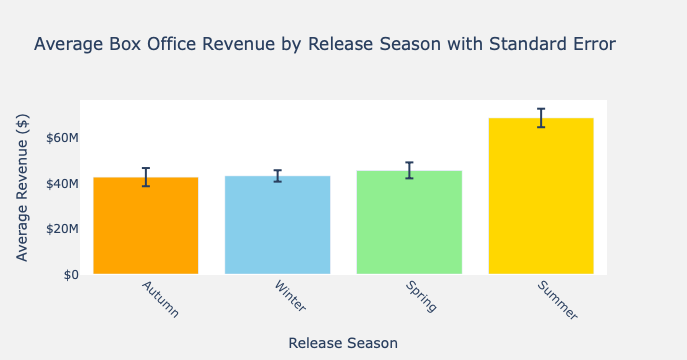

In [230]:

release_season_stats = df_period_season3.groupby('release_season')['Movie_box_office_revenue'].agg(['mean', 'sem']).sort_values(by='mean')

# Create a Plotly bar chart with error bars for each release season
fig = go.Figure()

# Adding bars for average box office revenue
fig.add_trace(go.Bar(
    x=release_season_stats.index,
    y=release_season_stats['mean'],
    name='Average Revenue',
    marker_color=['orange', 'skyblue', 'lightgreen', 'gold'],
    error_y=dict(type='data', array=release_season_stats['sem'], visible=True),
))

# Update layout for a more polished look
fig.update_layout(
    title='Average Box Office Revenue by Release Season with Standard Error',
    xaxis_title='Release Season',
    yaxis_title='Average Revenue ($)',
    xaxis=dict(tickangle=45),  # Rotate x-axis labels for better readability
    yaxis=dict(tickprefix="$"),  # Format y-axis with dollar sign
    bargap=0.2,  # Set the gap between bars for better spacing
    plot_bgcolor='rgb(255, 255, 255)',  # Set the plot background to white
    paper_bgcolor='rgb(242, 242, 242)',  # Set the background of the paper (outside the plot)
)

# Show the plot
fig.show()
fig.write_html("plots/seasonal_release_chapter4.html")

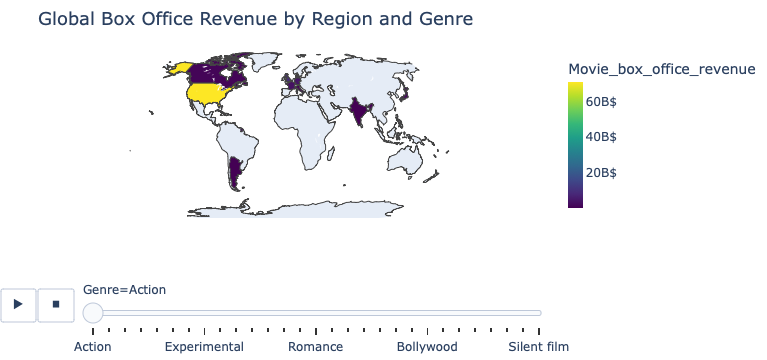

In [322]:
def create_global_box_office_map_with_dummies(df):
    # Identify dummied country and genre columns
    country_columns = [col for col in df.columns if col.startswith('Country_')]
    genre_columns = [col for col in df.columns if col.startswith('Genre_')]
    
    if not country_columns:
        raise ValueError("No country columns detected in the DataFrame. Ensure dummied countries exist.")
    if not genre_columns:
        raise ValueError("No genre columns detected in the DataFrame. Ensure dummied genres exist.")
    
    # Convert dummied countries to a single 'Country' column
    country_df = df.melt(
        id_vars=['Year', 'Movie_box_office_revenue'] + genre_columns, 
        value_vars=country_columns, 
        var_name='Country', 
        value_name='Is_Country'
    )
    country_df = country_df[country_df['Is_Country'] == 1]  # Keep only rows where country is active
    country_df['Country'] = country_df['Country'].str.replace('Country_', '', regex=False)  # Clean country names
    
    # Convert dummied genres to a single 'Genre' column
    genre_country_df = country_df.melt(
        id_vars=['Year', 'Country', 'Movie_box_office_revenue'], 
        value_vars=genre_columns, 
        var_name='Genre', 
        value_name='Is_Genre'
    )
    genre_country_df = genre_country_df[genre_country_df['Is_Genre'] == 1]  # Keep only rows where genre is active
    genre_country_df['Genre'] = genre_country_df['Genre'].str.replace('Genre_', '', regex=False)  # Clean genre names
    
    # Aggregate revenue by country and genre
    aggregated_data = (
        genre_country_df.groupby(['Country', 'Genre'])
        .agg({'Movie_box_office_revenue': 'sum'})
        .reset_index()
    )
    
    # Create the choropleth map
    fig = px.choropleth(
        aggregated_data,
        locations='Country',
        locationmode='country names',  # Match countries using names
        color='Movie_box_office_revenue',
        hover_name='Movie_box_office_revenue',
        animation_frame='Genre',  # Switch between genres
        title="Global Box Office Revenue by Region and Genre",
        color_continuous_scale='Viridis'
    )
    
    fig.update_layout(
        geo=dict(
            showframe=False,
            showcoastlines=True,
            projection_type='natural earth'
        ),
        coloraxis_colorbar=dict(
            title='Movie_box_office_revenue',
            ticksuffix='$',
            thickness=15
        ),
        title_font=dict(size=18),
        margin=dict(l=0, r=0, t=50, b=0)
    )
    
    return fig

# Example usage (assuming 'df' is your dataframe)
global_box_office_fig = create_global_box_office_map_with_dummies(df)
global_box_office_fig.show()
global_box_office_fig.write_html("plots/box_office_per_genre_country_chapter4.html")


# 2000-2015

In [266]:
period4 = periods[4]
df_period4 = movies_season[movies_season["Year_Interval"]==period4].copy()
char4 = characters_clean[characters_clean["Year_Interval"]==period4].copy()

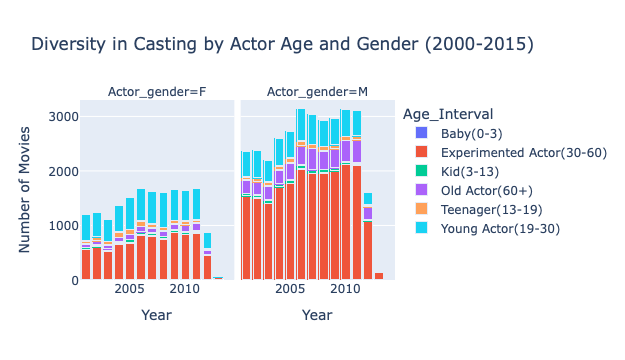

In [271]:
# Assuming df has 'Year', 'Actor_Age', and 'Actor_Gender' columns

# Count the number of movies per year for each age group and gender
df_age_gender_grouped = char4.groupby(['Year', 'Age_Interval', 'Actor_gender']).size().reset_index(name='Movies_Count')

# Create the bar plot
fig = px.bar(df_age_gender_grouped, x="Year", y="Movies_Count", color="Age_Interval", 
             facet_col="Actor_gender", barmode="stack", title="Diversity in Casting by Actor Age and Gender (2000-2015)")
fig.update_layout(xaxis_title="Year", yaxis_title="Number of Movies")
fig.show()
fig.write_html("plots/diversity_chapter5.html")

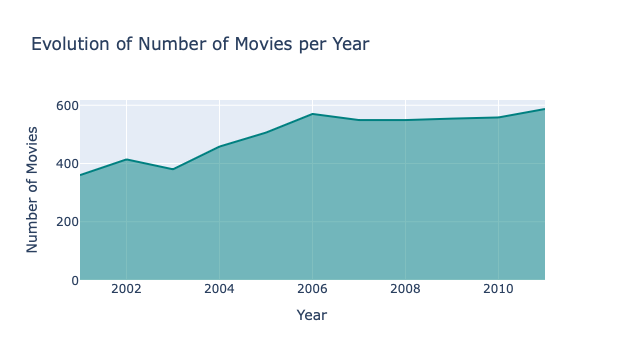

In [279]:
# Assuming you already have the 'movies_per_year' data
# Create a line plot with filled area beneath the curve
fig = go.Figure()

movies_per_year = df_period4[df_period4['Year']<2012]['Year'].value_counts().sort_index()

fig.add_trace(go.Scatter(
    x=movies_per_year.index, 
    y=movies_per_year.values, 
    mode='lines', 
    line=dict(color='teal'),
    fill='tozeroy',  # This will fill the area beneath the line
    fillcolor='rgba(0,128,128,0.5)',  # Set the fill color with transparency
    name='Movies per Year'
))

# Customize layout
fig.update_layout(
    title="Evolution of Number of Movies per Year",
    xaxis_title="Year",
    yaxis_title="Number of Movies",
    showlegend=False,  # Hide the legend as it's not necessary
)

# Show the plot
fig.show()
fig.write_html("plots/nb_of_movies_increase_chapter5.html")

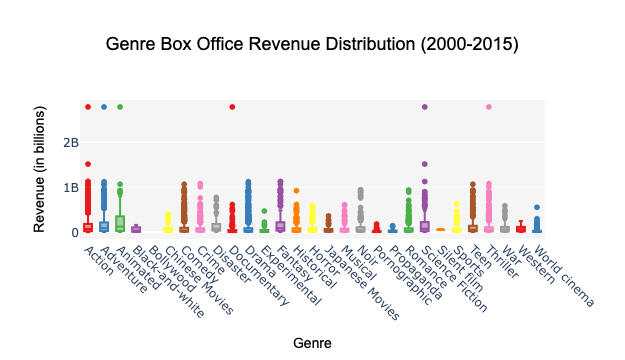

In [295]:
# Assuming df_period4 contains the necessary columns with dummied genres and 'Movie_box_office_revenue'
df = df_period4.copy()

# Melt the dataframe to long format, where 'Genre' column will have the genre names
df_melted = df.melt(id_vars=['Movie_box_office_revenue'], 
                    value_vars=[col for col in df.columns if col.startswith('Genre_')],
                    var_name='Genre', value_name='Is_Genre')

# Clean the Genre column names
df_melted["Genre"] = df_melted["Genre"].apply(lambda x: x.replace("Genre_", ""))

# Filter only rows where 'Is_Genre' is 1 (indicating the movie belongs to that genre)
df_genre_revenue = df_melted[df_melted['Is_Genre'] == 1]

# Create the box plot with a color palette and enhanced visual aesthetics
fig = px.box(df_genre_revenue, x="Genre", y="Movie_box_office_revenue", 
             title="Genre Box Office Revenue Distribution (2000-2015)",
             labels={"Genre": "Movie Genre", "Movie_box_office_revenue": "Revenue (in billions)"},
             color="Genre",  # Coloring by Genre for better differentiation
             color_discrete_sequence=px.colors.qualitative.Set1)  # Vibrant color palette

# Customize layout for better readability and visual appeal
fig.update_layout(
    title={'x': 0.5, 'xanchor': 'center'},  # Centering the title
    xaxis_title="Genre",
    yaxis_title="Revenue (in billions)",
    xaxis=dict(tickangle=45),  # Rotating x-axis labels for better readability
    plot_bgcolor="whitesmoke",  # Background color for a cleaner look
    showlegend=False,  # Disable legend for a cleaner plot
    title_font=dict(size=18, color='black', family='Arial'),
    xaxis_title_font=dict(size=14, color='black', family='Arial'),
    yaxis_title_font=dict(size=14, color='black', family='Arial')
)

# Show the plot
fig.show()

fig.write_html("plots/genre_box_office_chapter5.html")

/var/folders/gc/k740v3612cv_1m5s2d93wxzr0000gn/T/ipykernel_79750/3682843194.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



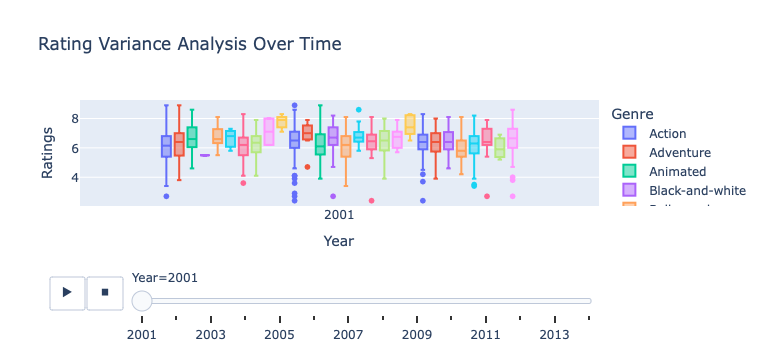

In [310]:
# Assuming df contains 'Year', 'averageRating', and genre dummy columns (e.g., 'Genre_Action', 'Genre_Comedy', etc.)
df = df_period4.copy()

# Melt the dataframe so that we can work with genres as a single column
df_melted = df.melt(id_vars=['Year', 'averageRating'], 
                    value_vars=[col for col in df.columns if col.startswith('Genre_')],
                    var_name='Genre', value_name='Is_Genre')

# Filter rows where the movie belongs to that genre (Is_Genre == 1)
df_genre = df_melted[df_melted['Is_Genre'] == 1]

# Remove 'Genre_' prefix for better labeling
df_genre['Genre'] = df_genre['Genre'].apply(lambda x: x.replace('Genre_', ''))

# Create the animated box plot for rating variance analysis
fig = px.box(df_genre, 
             x="Year",          # X-axis: Release Year
             y="averageRating",         # Y-axis: Movie Ratings
             color="Genre",             # Color by Genre
             animation_frame="Year",  # Animation by Year
             title="Rating Variance Analysis Over Time",
             labels={"Year": "Year", "averageRating": "Ratings", "Genre": "Genre"},
             category_orders={"Year": sorted(df["Year"].unique())}  # Sort years
)

fig.show()

# Save to HTML
fig.write_html("movie_ratings.html")


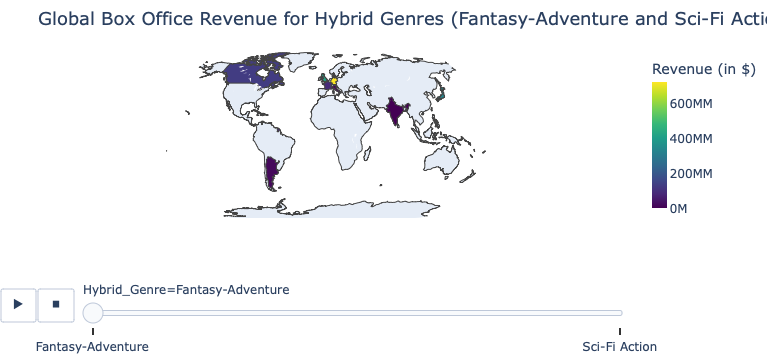

In [334]:
def create_hybrid_genre_map(df):
    # Step 1: Identify dummied columns
    country_columns = [col for col in df.columns if col.startswith('Country_') and not col=="Country_United States of America"]
    genre_columns = [col for col in df.columns if col.startswith('Genre_')]
    
    if not country_columns:
        raise ValueError("No country columns detected. Ensure dummied countries exist.")
    if not genre_columns:
        raise ValueError("No genre columns detected. Ensure dummied genres exist.")
    
    # Step 2: Convert dummied countries to a single 'Country' column
    country_df = df.melt(
        id_vars=['Year', 'Movie_box_office_revenue'] + genre_columns, 
        value_vars=country_columns, 
        var_name='Country', 
        value_name='Is_Country'
    )
    country_df = country_df[country_df['Is_Country'] == 1]  # Filter active countries
    country_df['Country'] = country_df['Country'].str.replace('Country_', '', regex=False)  # Clean names
    
    # Step 3: Define hybrid genres of interest
    hybrid_genres = {
        'Fantasy-Adventure': ['Genre_Fantasy', 'Genre_Adventure'],
        'Sci-Fi Action': ['Genre_Science Fiction', 'Genre_Action']
    }
    
    # Step 4: Calculate revenue for each hybrid genre
    hybrid_data = []
    for hybrid_name, genres in hybrid_genres.items():
        # Filter rows where all genres in the hybrid are present
        filtered_df = country_df[
            country_df[genres].all(axis=1)
        ]
        filtered_df = filtered_df.groupby(['Country'], as_index=False).agg({'Movie_box_office_revenue': 'sum'})
        filtered_df['Hybrid_Genre'] = hybrid_name
        hybrid_data.append(filtered_df)
    
    # Combine all hybrid data
    hybrid_genre_df = pd.concat(hybrid_data, ignore_index=True)
    
    # Step 5: Create choropleth map
    fig = px.choropleth(
        hybrid_genre_df,
        locations='Country',
        locationmode='country names',
        color='Movie_box_office_revenue',
        hover_name='Country',
        animation_frame='Hybrid_Genre',  # Toggle between Fantasy-Adventure and Sci-Fi Action
        title="Global Box Office Revenue for Hybrid Genres (Fantasy-Adventure and Sci-Fi Action)",
        color_continuous_scale='Viridis'
    )
    
    # Step 6: Customize layout
    fig.update_layout(
        geo=dict(
            showframe=False,
            showcoastlines=True,
            projection_type='natural earth'
        ),
        coloraxis_colorbar=dict(
            title='Revenue (in $)',
            ticksuffix='M',
            thickness=15
        ),
        title_font=dict(size=18),
        margin=dict(l=0, r=0, t=50, b=0)
    )
    
    return fig

# Example usage (assuming your dataframe is df)
hybrid_genre_map_fig = create_hybrid_genre_map(df)
hybrid_genre_map_fig.show()

hybrid_specific_map_fig.write_html("plots/hybrid_genres_chapter5.html")